In [1]:
import matplotlib.pyplot as plt
import numpy as np
from spectral import *
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es
import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)
import cv2 as cv     
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from numpy.random import seed
from time import time

### Change this random seed to fit different models
seed(11)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Debugging to make sure we are actually using the GPU
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


2022-05-21 18:01:31.559336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:01:31.676858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:01:31.677185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Load in the raw data
basePath = '/home/nathaniel/Downloads/'
raw_cube = np.load(basePath + '1.npy')
print(f'Data Shape: {raw_cube.shape[:-1]}\nNumber of Bands: {raw_cube.shape[-1]}')

# ### Load in the calibration files
# # Radiometric calibration - HSI
# dark_img = open_image('/home/nathaniel/ros_playground/src/cluttered_grasp/scripts/darkReference.hdr')
# data_dark = np.array(dark_img.load()).reshape(640,273)
# white_img = open_image('/home/nathaniel/ros_playground/src/cluttered_grasp/scripts/whiteReference.hdr')
# data_white = np.array(white_img.load()).reshape(640,273)

# # Radiometric calibration - Spectrometer
# dark_ref_spec = np.mean(data_dark, axis=0)
# white_ref_spec = np.mean(data_white, axis=0)

Data Shape: (3743, 640)
Number of Bands: 273


In [5]:
# Normalize the data
# data = np.zeros_like(raw_cube,dtype=np.uint8)
# for i in range(raw_cube.shape[0]):
#     data[i,:] = np.clip((raw_cube[i,:] - data_dark) / (data_white - data_dark),0,1)*255
    
# Denoise layers
#for w in tqdm(range(data.shape[2])):
#    data[:,:,w] = cv.fastNlMeansDenoising(data[:,:,w],None,10,9,21)

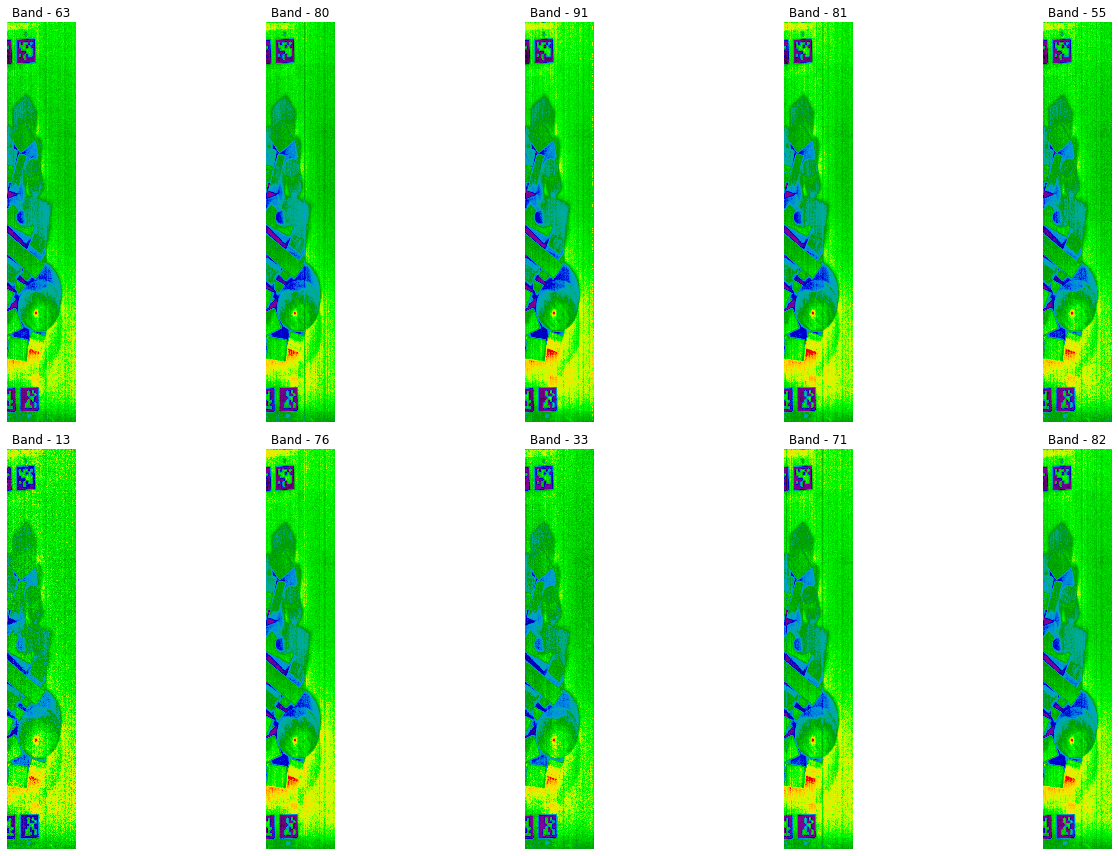

In [9]:
# Print 10 random channel images to confirm the data looks good
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)
for i in range(2):
    for j in range(5):
        c = np.random.randint(103)
        ax[i][j].imshow(raw_cube[:, :, c], cmap='nipy_spectral')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1
plt.tight_layout()
plt.show()

In [11]:
# Extract the data here
row,col,wave = raw_cube.shape

In [12]:
# encoder dimension
encoding_dim = 40
ncol = wave
input_dim = Input(shape = (ncol, ), name = 'InputLayer')

# Encoder Layers
encoded1 = Dense(100, activation = 'relu', name = 'EncodeLayer1')(input_dim)
encoded2 = Dense(90, activation = 'relu', name = 'EncodeLayer2')(encoded1)
encoded3 = Dense(85, activation = 'relu', name = 'EncodeLayer3')(encoded2)
encoded4 = Dense(80, activation = 'relu', name = 'EncodeLayer4')(encoded3)
encoded5 = Dense(75, activation = 'relu', name = 'EncodeLayer5')(encoded4)
encoded6 = Dense(70, activation = 'relu', name = 'EncodeLayer6')(encoded5)

# Coded Part
encoded7 = Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(encoded6)

# Decoder Layers
decoded1 = Dense(70, activation = 'relu', name = 'DecodeLayer1')(encoded7)
decoded2 = Dense(75, activation = 'relu', name = 'DecodeLayer2')(decoded1)
decoded3 = Dense(80, activation = 'relu', name = 'DecodeLayer3')(decoded2)
decoded4 = Dense(85, activation = 'relu', name = 'DecodeLayer4')(decoded3)
decoded5 = Dense(90, activation = 'relu', name = 'DecodeLayer5')(decoded4)
decoded6 = Dense(100, activation = 'relu', name = 'DecodeLayer6')(decoded5)
decoded7 = Dense(ncol, activation = 'sigmoid', name = 'OutputLayer')(decoded6)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded7)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 273)]             0         
                                                                 
 EncodeLayer1 (Dense)        (None, 100)               27400     
                                                                 
 EncodeLayer2 (Dense)        (None, 90)                9090      
                                                                 
 EncodeLayer3 (Dense)        (None, 85)                7735      
                                                                 
 EncodeLayer4 (Dense)        (None, 80)                6880      
                                                                 
 EncodeLayer5 (Dense)        (None, 75)                6075      
                                                                 
 EncodeLayer6 (Dense)        (None, 70)                5320  

2022-05-21 18:02:39.341976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-21 18:02:39.342418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:02:39.342572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:02:39.342676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [14]:
# Right now I am min-max scaling the data, ideally this should include normalization with the white/dark reference images
scaler = MinMaxScaler()
train_data = raw_cube.reshape((row*col,wave))
train_data = scaler.fit_transform(train_data)
X_train, X_test, y_train, y_test = train_test_split(
        train_data, train_data, test_size=0.33, random_state=42)

In [24]:
# Spectral Information Divergence - LOSS FUNCTION
def spectral_information_divergence(y,y_reconstructed):
    t = tf.divide(tf.transpose(y),tf.reduce_sum(tf.transpose(y),axis=0))
    r = tf.divide(tf.transpose(y_reconstructed),tf.reduce_sum(tf.transpose(y_reconstructed),axis=0))
    loss = tf.reduce_sum(tf.reduce_sum(tf.multiply(t,tf.log(tf.divide(t,r))), axis=0)
                         + tf.reduce_sum(tf.multiply(r,tf.log(tf.divide(r,t)))), axis=0)
    return loss

# Cosine of spectral angle loss - LOSS FUNCTION
def cos_spectral_angle_loss(y,y_reconstructed):
    normalize_r = tf.math.l2_normalize(tf.transpose(y_reconstructed),axis=0)
    normalize_t = tf.math.l2_normalize(tf.transpose(y),axis=0)
    loss = tf.reduce_sum(1-tf.reduce_sum(tf.multiply(normalize_r,normalize_t),axis=0))
    return loss

# Compile the Model
autoencoder.compile(optimizer = 'adam', 
                    loss = 'mse', 
                    metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()]
                    ) 

### Callbacks
## Early Stopping
early_stop = EarlyStopping(monitor = 'loss',
                            mode = 'min',
                            min_delta = 0.0,
                            patience = 5,
                            restore_best_weights = True)

## Checkpoint
checkpoint = ModelCheckpoint(filepath = 'hsi_autoencoder.h5', 
                             monitor = 'mean_squared_logarithmic_error', 
                             mode ='min', 
                             save_best_only = True)

## Tensorboard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Fit the Model
hist = autoencoder.fit(train_data, 
                       train_data, 
                       epochs = 50, 
                       batch_size = 512, 
                       shuffle = True, 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

Epoch 1/50
4679/4679 [==============================] - 10s 2ms/step - loss: 5.3581e-04 - mean_squared_logarithmic_error: 2.2868e-04
Epoch 2/50
4679/4679 [==============================] - 10s 2ms/step - loss: 4.5435e-04 - mean_squared_logarithmic_error: 1.9386e-04
Epoch 3/50
4679/4679 [==============================] - 10s 2ms/step - loss: 4.4524e-04 - mean_squared_logarithmic_error: 1.9010e-04
Epoch 4/50
4679/4679 [==============================] - 10s 2ms/step - loss: 4.4045e-04 - mean_squared_logarithmic_error: 1.8810e-04
Epoch 5/50
4679/4679 [==============================] - 9s 2ms/step - loss: 4.3697e-04 - mean_squared_logarithmic_error: 1.8665e-04
Epoch 6/50
4679/4679 [==============================] - 11s 2ms/step - loss: 4.3446e-04 - mean_squared_logarithmic_error: 1.8563e-04
Epoch 7/50
4679/4679 [==============================] - 11s 2ms/step - loss: 4.3398e-04 - mean_squared_logarithmic_error: 1.8547e-04
Epoch 8/50
4679/4679 [==============================] - 10s 2ms/step -

In [ ]:
2192*512

In [ ]:
train_data.shape

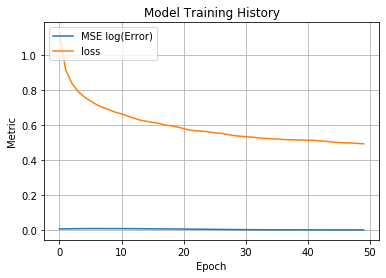

In [16]:
from matplotlib import pyplot as plt
plt.plot(hist.history['mean_squared_logarithmic_error'])
plt.plot(hist.history['loss'])
plt.title('Model Training History')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['MSE log(Error)', 'loss'], loc='upper left')
plt.grid()
plt.show()

In [17]:
prediction = np.zeros_like(train_data)
chunks = np.arange(0,train_data.shape[0]+1000,1000)
for i in range(len(chunks)-1):
    prediction[chunks[i]:chunks[i+1],:]= autoencoder(train_data[chunks[i]:chunks[i+1],:]).numpy()

In [18]:
pred_img = prediction.reshape(row,col,wave)

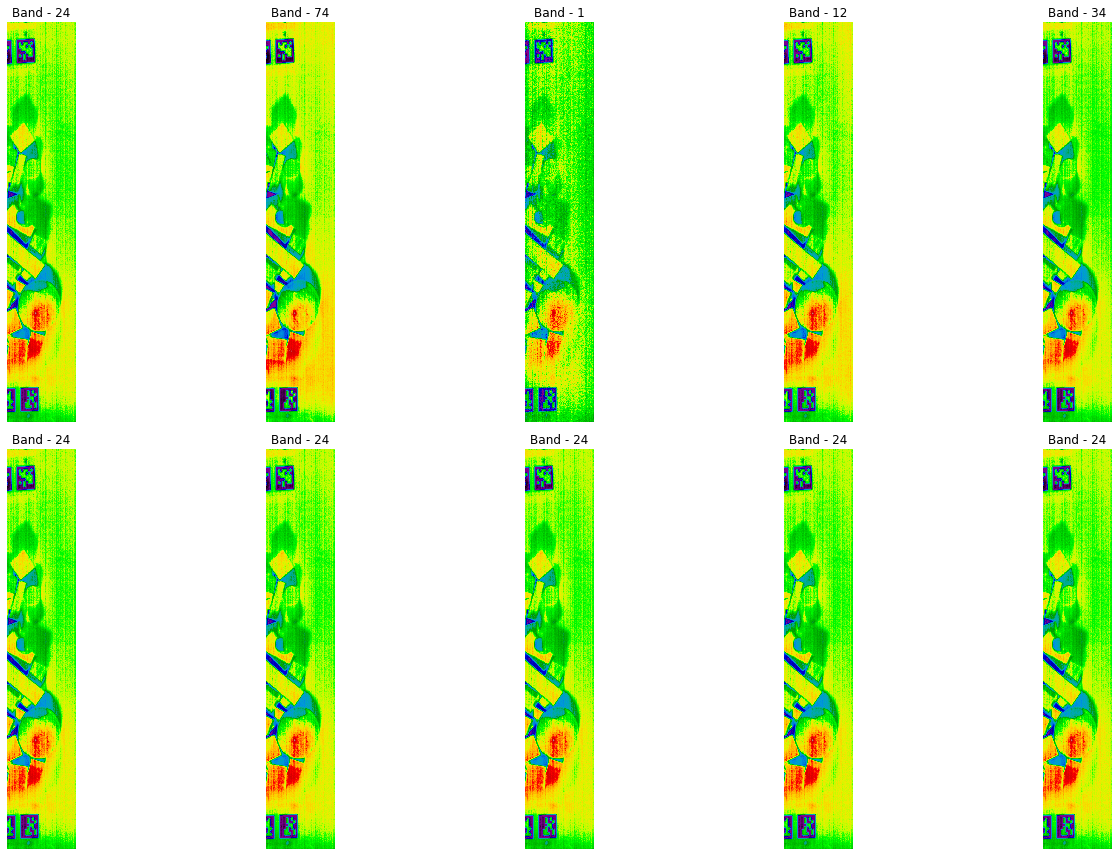

In [19]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)
c = np.random.randint(103,size=10)
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(pred_img[:, :, c[(i-1)*j]], cmap='nipy_spectral')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c[(i-1)*j]}")
plt.tight_layout()
plt.show()

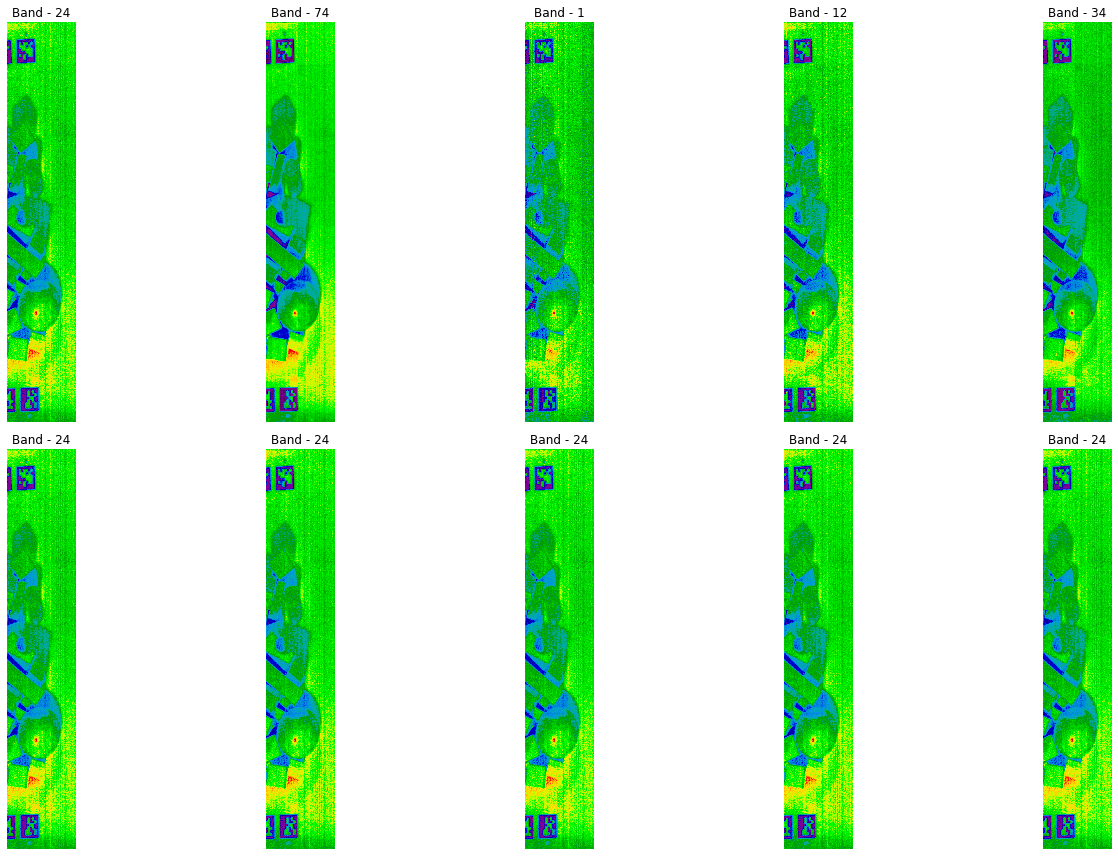

In [22]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(raw_cube[:, :, c[(i-1)*j]], cmap='nipy_spectral')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c[(i-1)*j]}")
plt.tight_layout()
plt.show()

In [60]:
import keras.backend as K
A = np.array([[1,2,3],[1,2,3]], dtype=np.float32)
B = np.array([[3,3,3],[1,2,3]], dtype=np.float32)
C = K.sum(A * B,axis=-1,keepdims=True).numpy()

In [63]:
tf.math.l2_normalize(A, 0, 0)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.7071067 , 0.7071067 , 0.70710677],
       [0.7071067 , 0.7071067 , 0.70710677]], dtype=float32)>

In [52]:
A**2

array([[1, 4, 9],
       [1, 4, 9]])

In [48]:
A**2

array([[1, 4, 9],
       [1, 4, 9]])

In [67]:
np.linalg.norm(B, axis=1)

array([5.196152 , 3.7416575], dtype=float32)

In [72]:
np.sum(np.dot(A,B.T), axis=1)

array([32., 32.], dtype=float32)

In [78]:
np.sum(A*B,axis=1)

array([18., 14.], dtype=float32)